In [1]:
import os
import copy
import stanza
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
#stanza.download('en')

nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,depparse')

2020-10-04 01:16:47 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-10-04 01:16:47 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-10-04 01:16:48 INFO: Use device: gpu
2020-10-04 01:16:48 INFO: Loading: tokenize
2020-10-04 01:16:52 INFO: Loading: pos
2020-10-04 01:16:54 INFO: Loading: lemma
2020-10-04 01:16:54 INFO: Loading: depparse
2020-10-04 01:16:55 INFO: Done loading processors!


In [160]:
relationPriority = {    
    "BIND": 9,
    "conj-verb": 10,
    "amod": 10,
    "compound": 10,
    "expl": 10,
    "det": 15,
    "cc": 15,
    "conj-adj": 16,
    "conj-np": 16,
    "appos": 16,
    "acl:relcl": 16,
    "acl": 16,
    "acl-other": 16,
    "cop": 20,
    "obj": 20,
    "obj:wh": 20,
    "obj-wh": 20,
    "auxpass": 30,
    "aux": 30,
    "xcomp": 30,
    "nmod:poss": 40,
    "nmod:npmod": 40,
    "nmod:tmod": 40,
    "nmod:count": 40,
    "nmod": 40,
    "obl": 40,
    "advmod": 40,
    "advmod:count": 40,
    "advcl": 40,
    "ccomp": 40,
    "conj-vp": 45,
    "nsubj": 60,
    "nsubjpass": 60,
    "nsubj-wh": 60,
    "case": 70,
    "conj-sent": 80,
    "punct": 90,
    "root": 90,
}


def dependencyParse(sentence):
    postag = {}
    parsed = nlp(sentence.lower())
    parse_tree = [postProcess(sent, word, postag) for sent in parsed.sentences for word in sent.words]
    return (parse_tree, postag)
    
def postProcess(sent, word, postag):
    if word.text not in postag:
        postag[word.text] = (word.id, word.upos, word.xpos)
    tree_node = [word.deprel, word.text, sent.words[word.head-1].text if word.head > 0 else "root"]
    printTree(tree_node, postag[word.text])
    return tree_node

def printTree(tree, tag):
    print(f'word: {tree[1]}\thead: {tree[2]}\tdeprel: {tree[0]} \tid: {tag[0]} \tnpos: {tag[1]} \txpos: {tag[2]}', sep='\n')

In [161]:
class BinaryDependencyTree:
    def __init__(self, val, left, right, wid=None, npos=None, xpos=None):
        self.val = val
        self.left = left
        self.right = right
        self.mark = "0"
        self.id = wid
        self.npos = npos
        self.xpos = xpos
        
    def isTree(self):
        return not (type(self.left) is str and type(self.right) is str)
    
    def getVal(self):
        return self.val
    
    def getLeft(self):
        return self.left
    
    def getRight(self):
        return self.right
    
class DependencyTree:
    def __init__(self, val, children):
        self.val = val
        self.children = children
        
    def isTree(self):
        return len(self.children) != 0
    
    def getVal(self):
        return self.val
    
    def getChildren(self):
        return self.children
    
    def addChildren(self, child):
        self.children.append(child)

In [162]:
def composeMulti(head, rel, parseTable):
    children = list(filter(lambda x: x[2] == head, parseTable))
    if len(children) == 0:
        return DependencyTree([rel, head], [])
    
    treeChildren = []
    for child in children:
        childTree = composeMulti(child[1], child[0], parseTable)
        treeChildren.append(childTree)
        
    depTree = DependencyTree([rel, head], treeChildren)
    return depTree

def makeDepTree(parseTable):
    root = list(filter(lambda x: x[2] == "root", parseTable))[0][1]
    return composeMulti(root, "root", parseTable) 


class Binarizer:
    def __init__(self, parseTable=None, postag=None):
        self.postag = postag
        self.parseTable = parseTable
        
    def compose(self, head):
        children = list(filter(lambda x: x[2] == head, self.parseTable))
        children.sort(key=(lambda x: relationPriority[x[0]]), reverse=True)
        if len(children) == 0:
            tag = self.postag[head]
            return BinaryDependencyTree(head, "N", "N", tag[0], tag[1], tag[2])
        else: 
            topDep = children[0]
        self.parseTable.remove(topDep)
        left = self.compose(topDep[1])
        right = self.compose(topDep[2])
        binaryTree = BinaryDependencyTree(topDep[0], left, right)
        return binaryTree

    def binarization(self):
        root = list(filter(lambda x: x[0] == "root", self.parseTable))[0][1]
        return self.compose(root)  
    

In [163]:
arrows = {
    "+" : "\u2191",
    "-" : "\u2193",
    "=" : "=",
    "0" : ""
}

def btreeToList(binaryDepdency):
    def toList(tree):
        treelist = []
        if tree.getVal() not in relationPriority:
            treelist.append(tree.npos)
            treelist.append(tree.getVal()+arrows[tree.mark])
        else:
            treelist.append(tree.getVal())
        
        left = tree.getLeft()
        right = tree.getRight()

        if left is not 'N':
            treelist.append(toList(left))
       
        if right is not 'N':
            treelist.append(toList(right))

        return treelist
    return toList(binaryDepdency)

def treeToList(depdency):
    def toList(tree):
        treelist = []
        val = tree.getVal()
        label = str(val[0]) + '<' +str(val[1]) + '>'
        treelist.append(label)
        
        children = tree.getChildren()
        for child in children:
            treelist.append(toList(child)) 

        return treelist
    return toList(depdency)

In [164]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [165]:
negate_mark = {
    "+":"-",
    "-":"+",
    "=":"="
}

det_mark = {
    "det:univ": ("+", "-"),
    "det:exist": ("+", "+"),
    "det:limit": ("+", "="),
    "det:negation": ("+", "-")
}

det_type_words = {
    "det:univ": ["all", "every", "each", "both"],
    "det:exist": ["a", "an", "some"],
    "det:limit": ["the", "this", "that", "those", "these", "my", "his", "her"],
    "det:negation": ["no"]
}

def det_type(word):
    for det in det_type_words:
        if word.lower() in det_type_words[det]:
            return det

In [169]:
class Polarizer:
    
    def __init__(self, dependtree):
        self.dependtree = dependtree
        self.polarize_function = {
            "nsubj": self.polarize_nsubj,
            "det": self.polarize_det
        }
        #self.isNegate = False
        
    def polarize_deptree(self):
        self.polarize(self.dependtree)
        #if self.isNegate:
        
    def polarize(self, tree):
        if tree.isTree():
            self.polarize_function[tree.val](tree)
        else:
            print(tree.val + tree.mark)

    def polarize_nsubj(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        if right.isTree():
            self.polarize(right)
        else:
            right.mark = '+'
        if left.isTree():
            self.polarize(left)
        else:
            left.mark = '+'
        
    def polarize_det(self, tree):
        right = tree.getRight()
        left = tree.getLeft()
        
        detType = det_type(left.val)
        #print(left.val)
        #print(detType)
        detMark = det_mark[detType]
        
        tree.right.mark = detMark[1]
        
        if right.isTree():
            self.polarize(right)
        
        left.mark = detMark[0]
        if detType == "det:negation":
            #self.isNegate = True
            self.negate(self.dependtree)
            
    def negate(self, tree):
        if tree.isTree():
            if tree.val != "det":
                self.negate(tree.getRight())
                self.negate(tree.getLeft())
                if tree.mark != "0":
                    tree.mark = negate_mark[tree.mark]
        else:
            tree.mark = negate_mark[tree.mark]

All dogs eat
word: all	head: dogs	deprel: det 	id: 1 	npos: DET 	xpos: DT
word: dogs	head: eat	deprel: nsubj 	id: 2 	npos: NOUN 	xpos: NNS
word: eat	head: root	deprel: root 	id: 3 	npos: VERB 	xpos: VBP
[nsubj  [det  [DET  all↑]  [NOUN  dogs↓]]  [VERB  eat↑]]


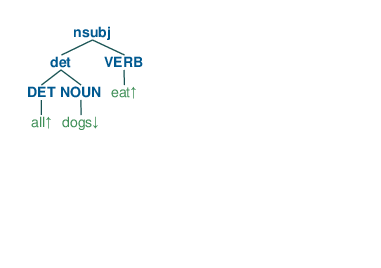

No dog eats
word: no	head: dog	deprel: det 	id: 1 	npos: DET 	xpos: DT
word: dog	head: eats	deprel: nsubj 	id: 2 	npos: NOUN 	xpos: NN
word: eats	head: root	deprel: root 	id: 3 	npos: VERB 	xpos: VBZ
[nsubj  [det  [DET  no↑]  [NOUN  dog↓]]  [VERB  eats↓]]


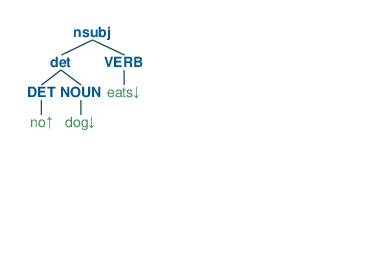

Some dogs eat
word: some	head: dogs	deprel: det 	id: 1 	npos: DET 	xpos: DT
word: dogs	head: eat	deprel: nsubj 	id: 2 	npos: NOUN 	xpos: NNS
word: eat	head: root	deprel: root 	id: 3 	npos: VERB 	xpos: VBP
[nsubj  [det  [DET  some↑]  [NOUN  dogs↑]]  [VERB  eat↑]]


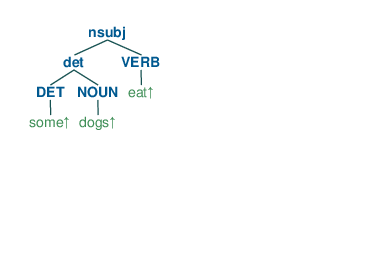

A dog eats
word: a	head: dog	deprel: det 	id: 1 	npos: DET 	xpos: DT
word: dog	head: eats	deprel: nsubj 	id: 2 	npos: NOUN 	xpos: NN
word: eats	head: root	deprel: root 	id: 3 	npos: VERB 	xpos: VBZ
[nsubj  [det  [DET  a↑]  [NOUN  dog↑]]  [VERB  eats↑]]


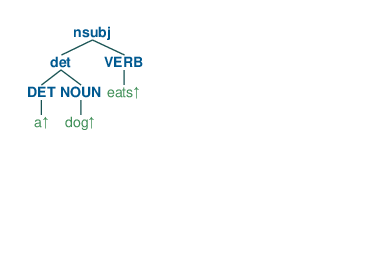

This dog eats
word: this	head: dog	deprel: det 	id: 1 	npos: DET 	xpos: DT
word: dog	head: eats	deprel: nsubj 	id: 2 	npos: NOUN 	xpos: NN
word: eats	head: root	deprel: root 	id: 3 	npos: VERB 	xpos: VBZ
[nsubj  [det  [DET  this↑]  [NOUN  dog=]]  [VERB  eats↑]]


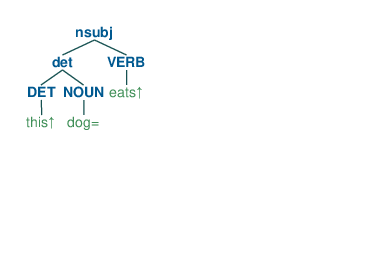

In [170]:
sentences = ["All dogs eat", "No dog eats", "Some dogs eat", "A dog eats", "This dog eats"]
#["A school girl with a black bag is on a crowded train", "every animal likes some young semanticist"] 
#"Every good student study the math", "Every young student play the piano", 
#"Some doctors work with no chemist", "Disney won an Oscar for the movie Avengers",
#"There are no dogs that chase cats"

binarizer = Binarizer()

for sent in sentences:
    print(sent)
    tree, postag = dependencyParse(sent)
    parseTreeCopy = copy.deepcopy(tree)
    
    # binarization
    binarizer.parseTable = parseTreeCopy
    binarizer.postag = postag
    binaryDepdency = binarizer.binarization()
    
    # polarization
    polarizer = Polarizer(binaryDepdency)
    polarizer.polarize_deptree()
    
    # postprocessing
    sexpression = str(btreeToList(binaryDepdency)).replace(',', ' ').replace("'", '')
    print(sexpression)
    sexpression = sexpression.replace('[', '(').replace(']', ')')
    
    #visualization
    btreeViz = Tree.fromstring(sexpression)
    jupyter_draw_nltk_tree(btreeViz)